In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
from netCDF4 import Dataset
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


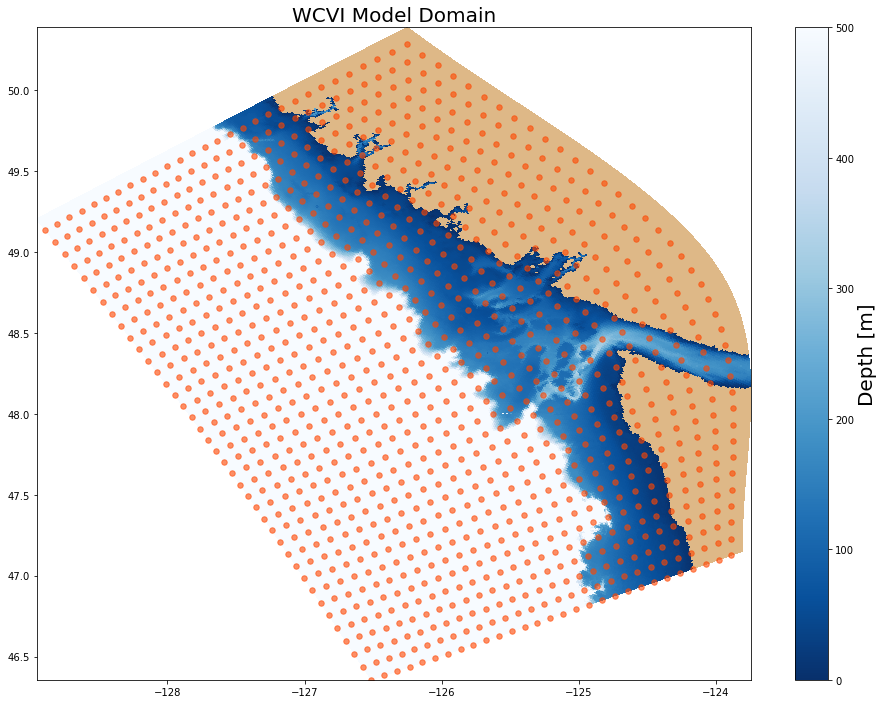

In [5]:
bathy = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/bathy_meter.nc')

Z = bathy.variables['Bathymetry'][:]


grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')


lon = grid['glamt'][0,...]
lat = grid['gphit'][0,...]

z0 = np.ma.masked_values(Z, 0)
# plt.plot(lon[::10,::10],lat[::10,::10],'m.')
cmap = plt.get_cmap('Blues_r')
# cmap.set_bad('gainsboro')
# cmap = cmo.cm.deep
cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
p = ax.pcolormesh(lon, lat, z0, cmap=cmap, vmin=0, vmax=500)
n=10
ax.scatter(lon[::n,::n], lat[::n,::n], c='orangered', s=30, alpha=0.6)
ax.set_xlim([lon.min(), lon.max()])
ax.set_ylim([lat.min(), lat.max()])
ax.set_title('WCVI Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, color='burlywood')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
plt.savefig('domain.png')

### Points for vertical section

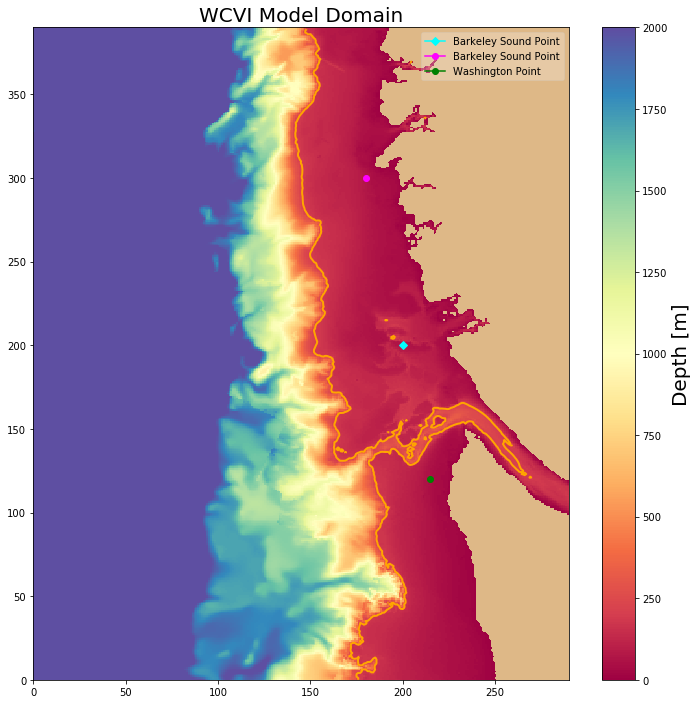

In [6]:
grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')



x_slice = np.arange(Z.shape[1])
y_slice = np.arange(Z.shape[0])

lon = grid['glamt'][0,...]
lat = grid['gphit'][0,...]

z0 = np.ma.masked_values(Z, 0)
# plt.plot(lon[::10,::10],lat[::10,::10],'m.')
cmap = plt.get_cmap('Spectral')
# cmap.set_bad('gainsboro')
# cmap = cmo.cm.deep
cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(12,12)); ax.grid()
p = ax.pcolormesh(z0, cmap=cmap, vmin=0)#, vmax=500)
n=10
# ax.scatter(lon[::n,::n], lat[::n,::n], c='orangered', s=30, alpha=0.6)
# ax.set_xlim([lon.min(), lon.max()])
# ax.set_ylim([lat.min(), lat.max()])



ax.set_title('WCVI Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, color='burlywood')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
CS = ax.contour(z0, levels = [200], colors=('orange',),linestyles=('-',),linewidths=(2,))
ax.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='D', color='cyan',
    label='Barkeley Sound Point',)
ax.plot(
    x_slice[180], y_slice[300],
    linestyle='-', marker='o', color='magenta',
    label='Esteban Point',)
ax.plot(
    x_slice[215], y_slice[120],
    linestyle='-', marker='o', color='green',
    label='Washington Point',)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)
# plt.savefig('domain.png')

In [7]:
u_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/ORCINUS_RESULTS/full_config_30_days/WCVI_1h_20160402_20160509_grid_U.nc')
v_vel = nc.Dataset('/ocean/ssahu/CANYONS/Results/ORCINUS_RESULTS/full_config_30_days/WCVI_1h_20160402_20160509_grid_V.nc')



tracers = nc.Dataset('/ocean/ssahu/CANYONS/Results/ORCINUS_RESULTS/full_config_30_days/WCVI_1h_20160402_20160509_grid_T.nc')



ssh = tracers.variables['sossheig']
lats = tracers.variables['nav_lat']
lons = tracers.variables['nav_lon']
sal = tracers.variables['vosaline']



ugrid = u_vel.variables['vozocrtx']
vgrid = v_vel.variables['vomecrty']

zlevels = u_vel.variables['depthu']
timesteps = u_vel.variables['time_counter']
lat = u_vel.variables['nav_lat']
lon = u_vel.variables['nav_lon']

### 1) Esteban Point (Upwelliing and downwelling)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


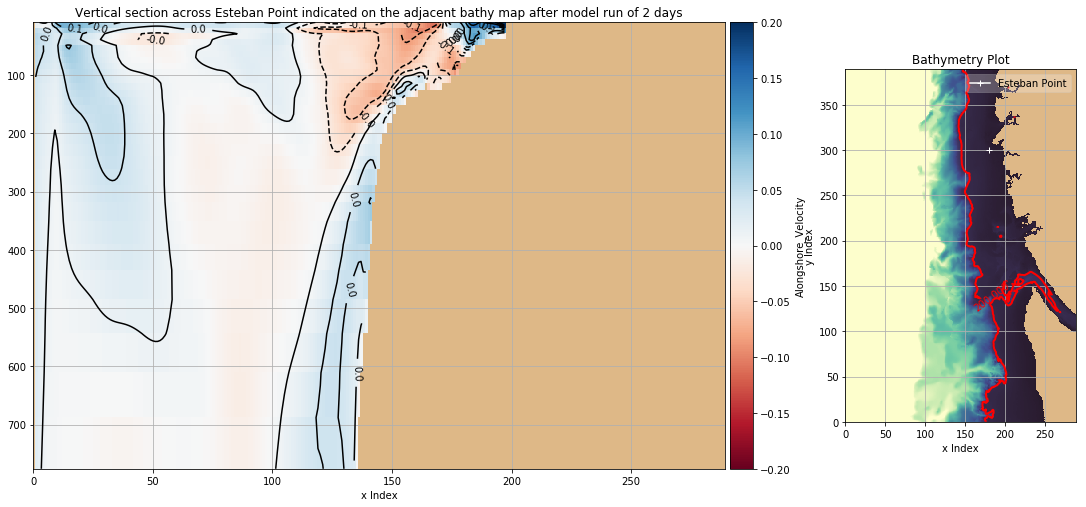

In [8]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathymetry = bathy
x_slice = np.arange(Z.shape[1])
y_slice = np.arange(Z.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[180], y_slice[300],
    linestyle='-', marker='+', color='white',
    label='Esteban Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 47 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,300,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,300,x_slice], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


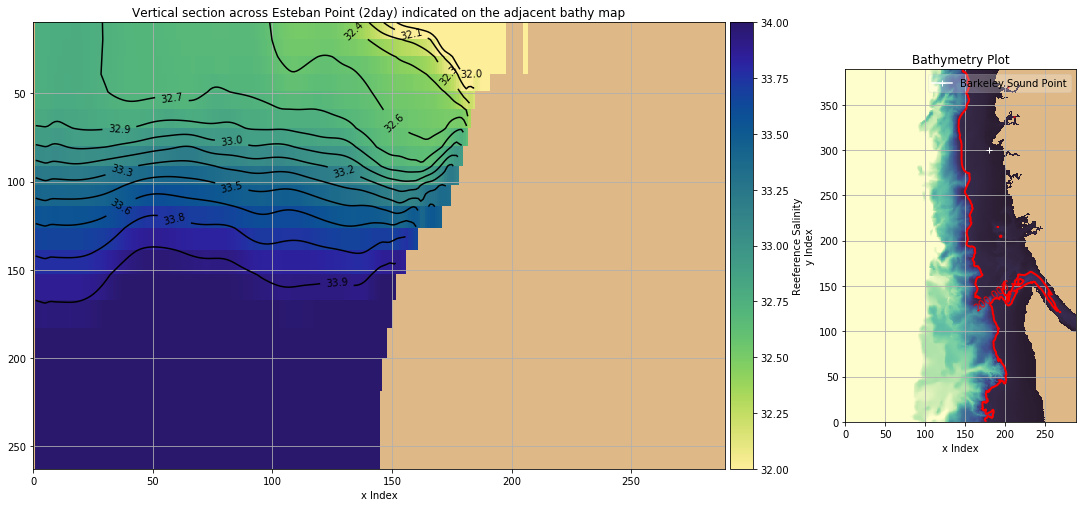

In [59]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[180], y_slice[300],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Esteban Point (2day) indicated on the adjacent bathy map')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


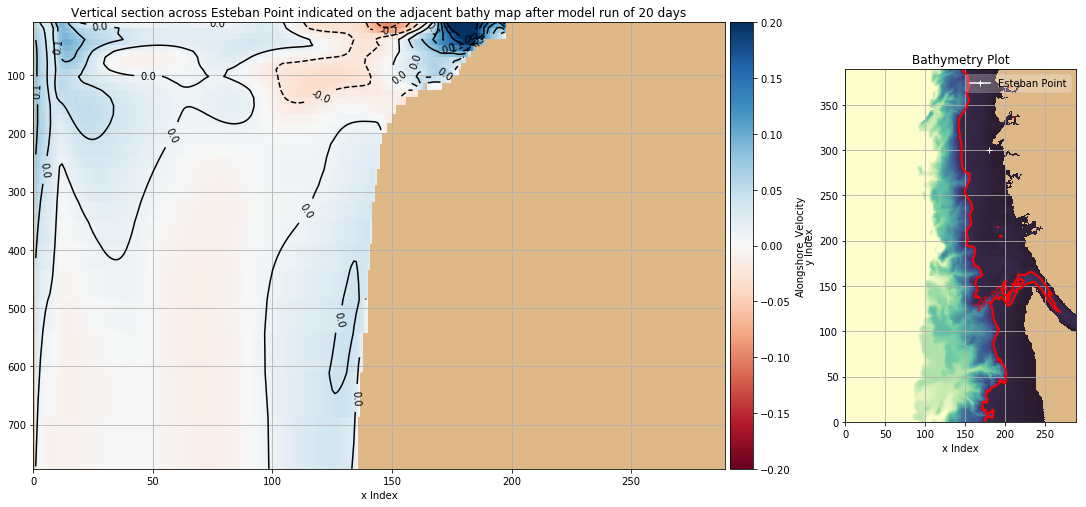

In [9]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathymetry = bathy
x_slice = np.arange(Z.shape[1])
y_slice = np.arange(Z.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[180], y_slice[300],
    linestyle='-', marker='+', color='white',
    label='Esteban Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 479 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,300,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,300,x_slice], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 20 days')

#### 1) Why do we not see a shelf break current here ?

#### 2) What happens to the California undercurrent through April (Does it confirm to Thomson and Krassovski 2015)

#### 3) What does the wind stress time series say at this point ?

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


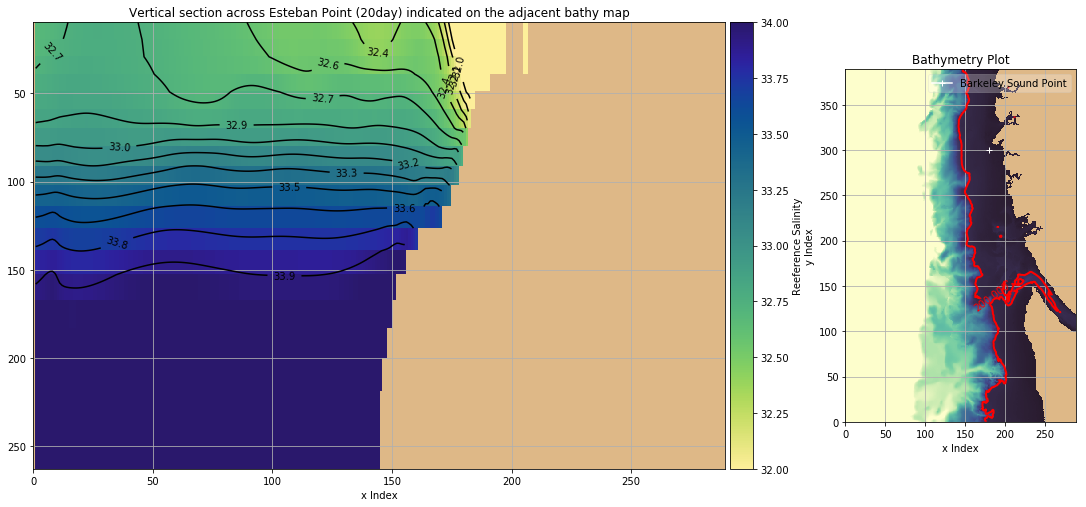

In [62]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[180], y_slice[300],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 479 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Esteban Point (20day) indicated on the adjacent bathy map')

### 2) Coast of Washington

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


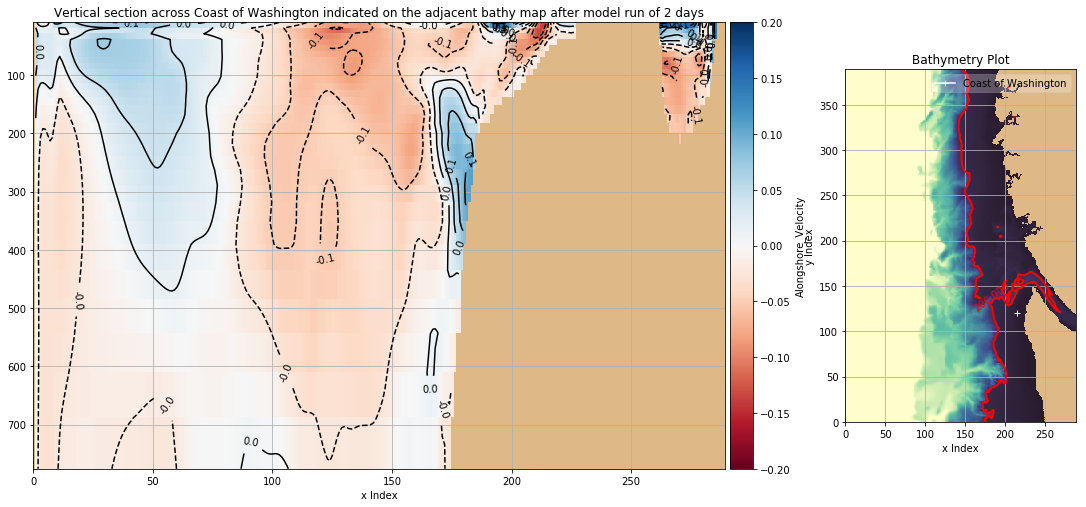

In [35]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathymetry = bathy
x_slice = np.arange(Z.shape[1])
y_slice = np.arange(Z.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[215], y_slice[120],
    linestyle='-', marker='+', color='white',
    label='Coast of Washington',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 47 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,120,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,120,x_slice], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Coast of Washington indicated on the adjacent bathy map after model run of 2 days')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


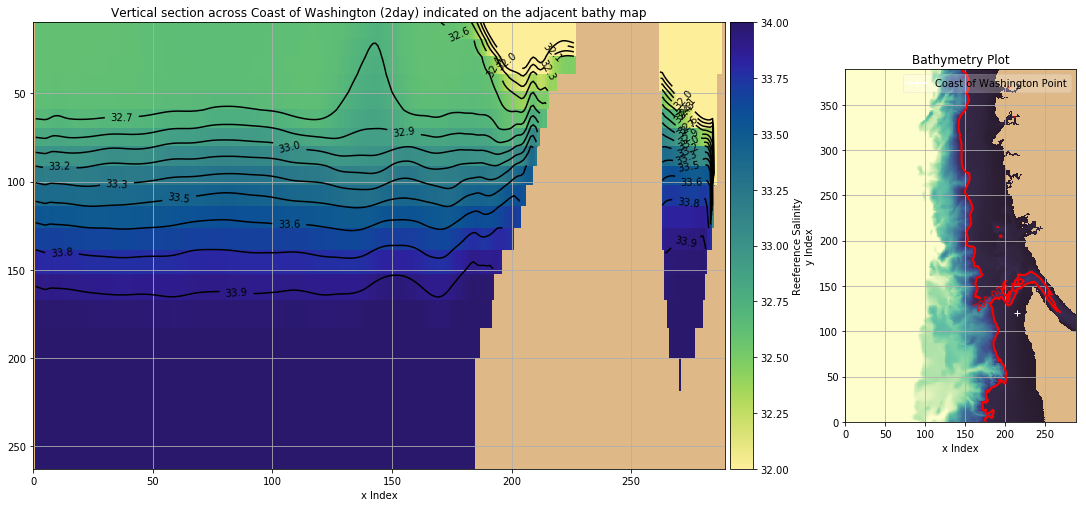

In [63]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[215], y_slice[120],
    linestyle='-', marker='+', color='white',
    label='Coast of Washington Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,120,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,120,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Coast of Washington (2day) indicated on the adjacent bathy map')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


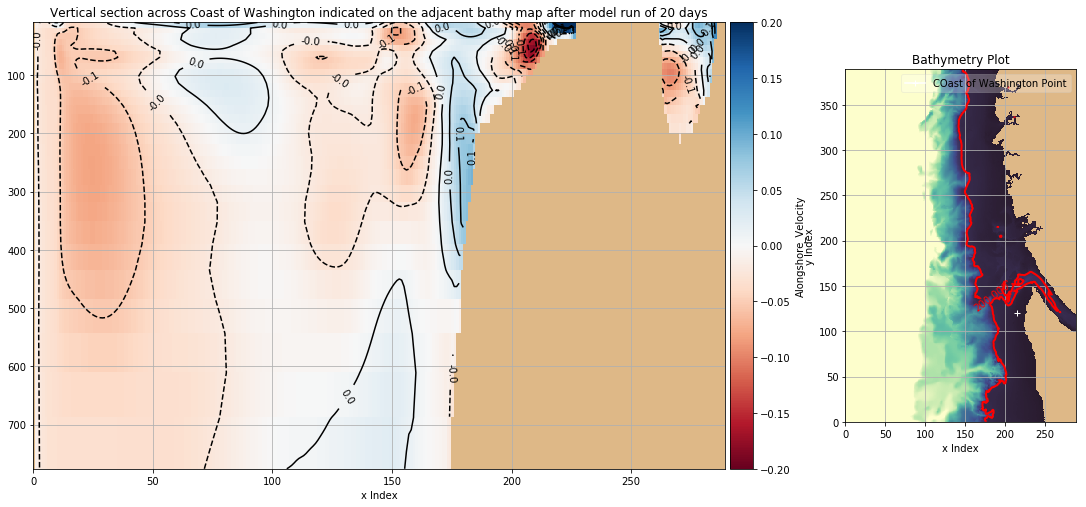

In [39]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathymetry = bathy
x_slice = np.arange(Z.shape[1])
y_slice = np.arange(Z.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[215], y_slice[120],
    linestyle='-', marker='+', color='white',
    label='COast of Washington Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 479 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,120,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,120,x_slice], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Coast of Washington indicated on the adjacent bathy map after model run of 20 days')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


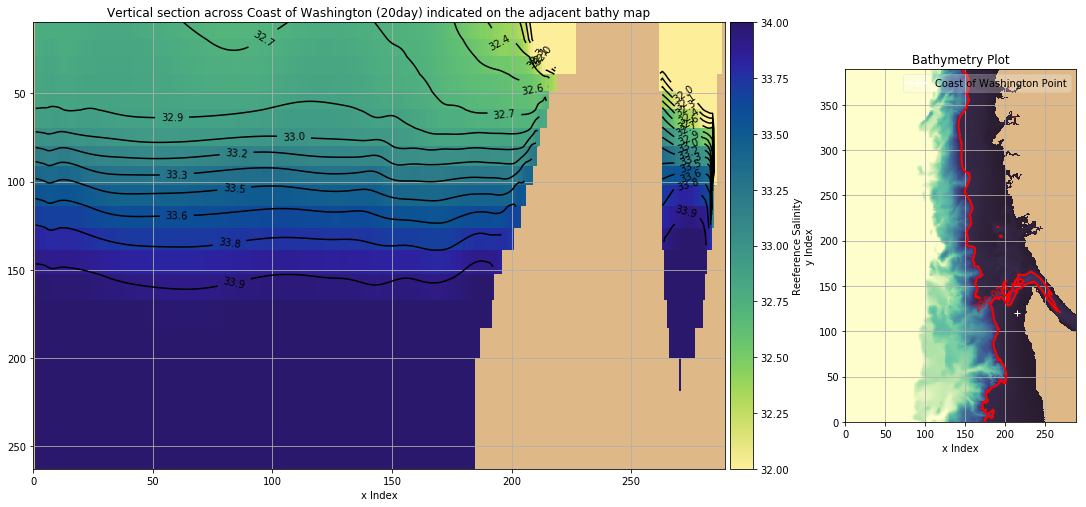

In [64]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[215], y_slice[120],
    linestyle='-', marker='+', color='white',
    label='Coast of Washington Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 479 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,120,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,120,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Coast of Washington (20day) indicated on the adjacent bathy map')

### 3) Barkley Sound

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


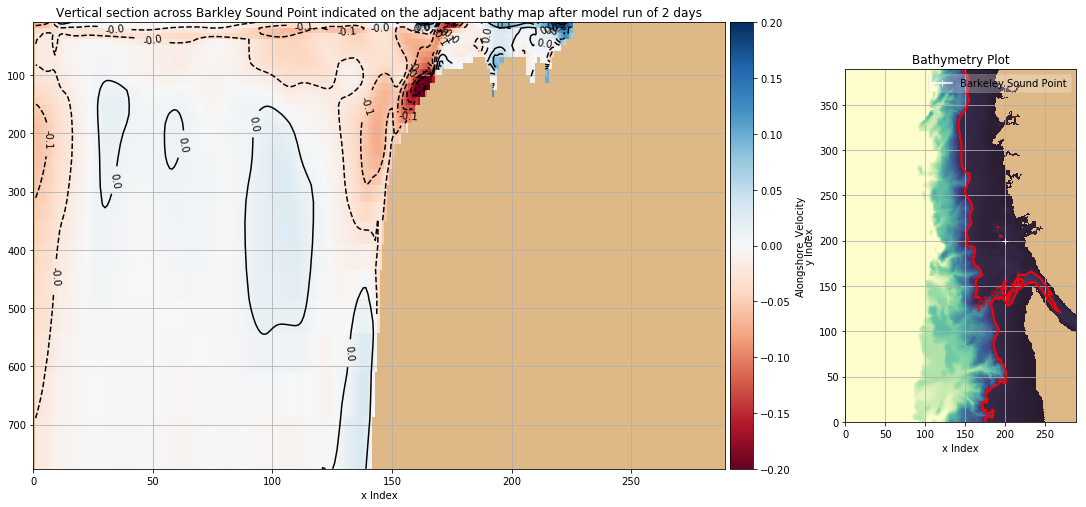

In [44]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathymetry = bathy
x_slice = np.arange(Z.shape[1])
y_slice = np.arange(Z.shape[0])
axr.pcolormesh(x_slice, y_slice,Z, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 47 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,200,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,200,x_slice], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map after model run of 2 days')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


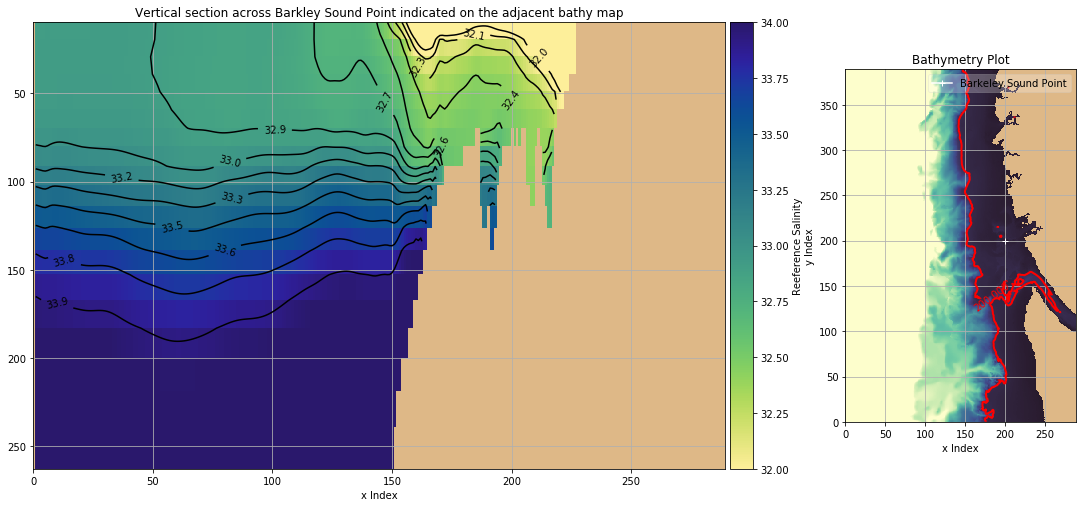

In [48]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


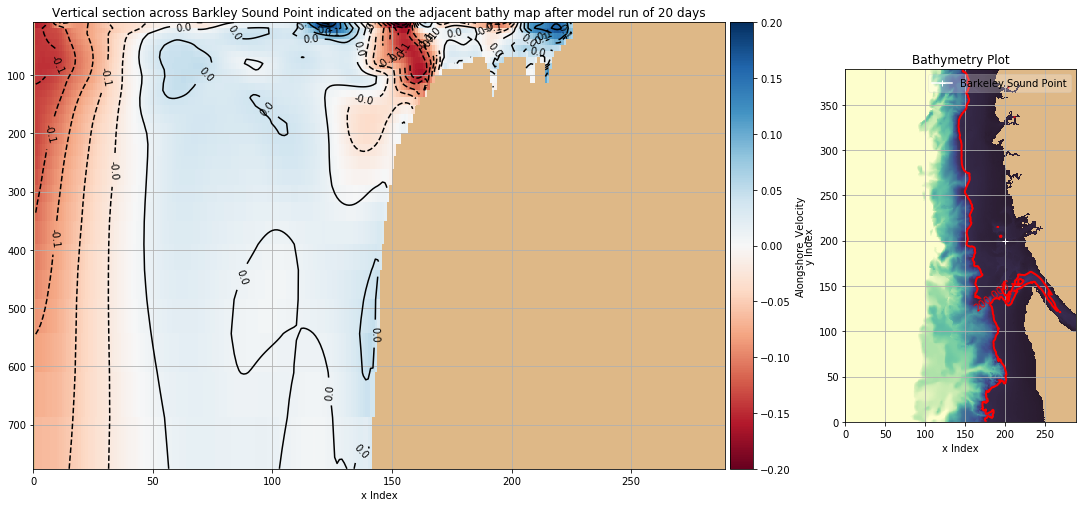

In [43]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathymetry = bathy
x_slice = np.arange(Z.shape[1])
y_slice = np.arange(Z.shape[0])
axr.pcolormesh(x_slice, y_slice,Z, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 479 

v_0 = vgrid[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_slice, zlevels[:30], v_masked[:30,200,x_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_slice, zlevels[:30], v_masked[:30,200,x_slice], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map after model run of 20 days')

#### We do have a surface intersified shelf break current in this region after 20 days of run; question is are we supposed to see such a current (surface intersified with a baroclinic structure) only in Barkley sound or near Esteban point and washington coasts (which we can't see) ?

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


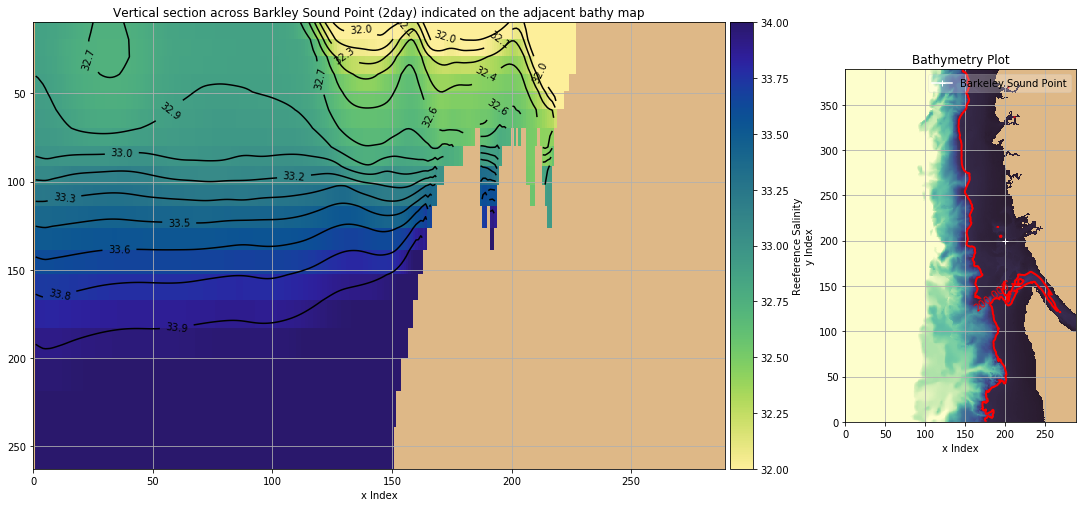

In [58]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[200],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 479 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,200,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point (2day) indicated on the adjacent bathy map')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


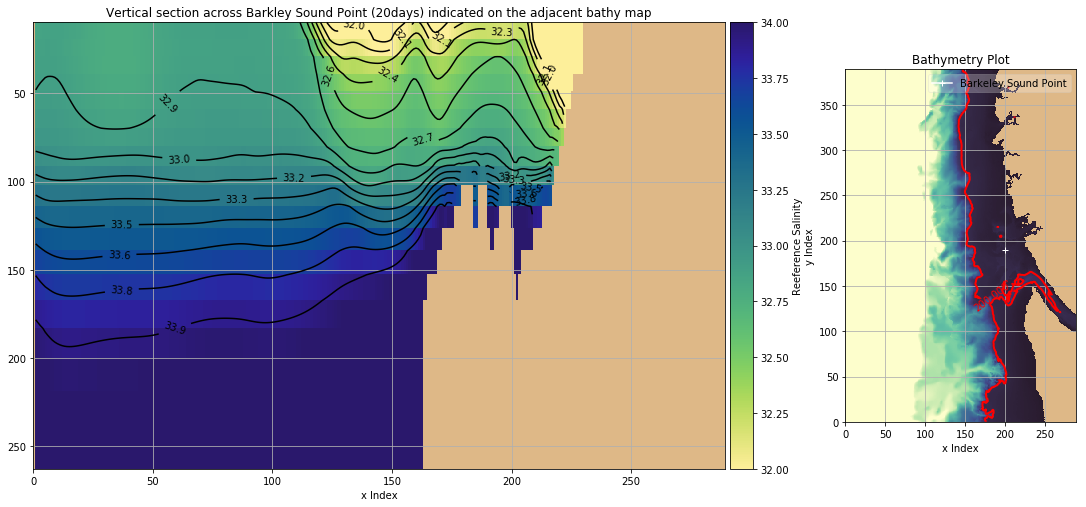

In [52]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[200], y_slice[190],
    linestyle='-', marker='+', color='white',
    label='Barkeley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 479 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,190,x_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reeference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,190,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point (20days) indicated on the adjacent bathy map')

### What information is there in the NEP036 model (used as IC and BC to WCVI NEMO) ?

Salinity for day 2 and day 20

In [ ]:
import numpy as np
import netCDF4 as nc
import xarray as xr
from scipy.interpolate import griddata, interp1d
from salishsea_tools import (nc_tools, gsw_calls,viz_tools)
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm

fname = '/home/ssahu/saurav/JP_BC/cat_42_days_T.nc'

gridT = xr.open_dataset(fname)

mask = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/meshmask_files/JP_mesh_mask.nc')

tmask_JP = mask.variables['tmask'][0,:,55:420,446:730]



vosaline_JP = np.array(gridT['vosaline'][2,:,55:420,446:730])
vosaline_JP[...] = np.ma.masked_array(vosaline_JP[...], mask = tmask_JP[...])
vosaline_JP[vosaline_JP == 0] = ['Nan']

glamt_bc_JP = np.array(gridT['nav_lon'][55:420,446:730])
gphit_bc_JP = np.array(gridT['nav_lat'][55:420,446:730])
deptht_JP = np.array(gridT['deptht'][:])

print("Removing Nan values from JP's data, since we replaced the zero masks with Nans")



#fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc'

with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...];

X = glamt_bc_JP.flatten();

Y = gphit_bc_JP.flatten();

points = (X[:],Y[:]);

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

vosaline_ic = np.empty((vosaline_JP.shape[0], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));

for i in np.arange(votemper_JP.shape[0]):
    vosaline_ic[i,...] = np.reshape(griddata(points, vosaline_JP[i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)



print("Interpolation to WCVI horizontal points successful")

print("Calling GSW tools to convert to Conservative Temperature and Reference Salinity")


lat = np.empty_like(gphit_wcvi)
lon = np.empty_like(gphit_wcvi)
depth = np.empty_like(deptht_JP)

lat[:] = gphit_wcvi[:]
lon[:] = glamt_wcvi[:]

depth[:] = deptht_JP[:]

z = np.multiply(depth[:],-1)


vosaline_PSU =np.empty_like(vosaline_ic)  

 

vosaline_PSU[:] = vosaline_ic[:]

pressure = np.empty(z.shape)
lats = np.empty(pressure.shape)
lons = np.empty(pressure.shape)
lats[:] = np.mean(lat)
lons[:] = np.mean(lon)


vosaline_SA = np.empty(vosaline_PSU.shape)
vosaline_RS = np.empty(vosaline_PSU.shape)


pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)])

print("Converted z to p: first GSW call successful")

for i in np.arange(vosaline_SA.shape[0]):
    vosaline_SA[i,...] = gsw_calls.generic_gsw_caller('gsw_SA_from_SP', [vosaline_PSU[i,...],pressure[i],lons[i],lats[i]])

print("Got SA from SP: GSW ran successfully inside loop")

vosaline_RS[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_PSU[:]])

print("Reference Salinity obtained from PS: one more GSW call left")




print("GSW Calls successfull")

mask_wcvi = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/meshmask_files/mesh_mask_high_res.nc')

NEMO_depth = mask_wcvi.variables['gdept_0'][0,:,0,0]
tmask_WCVI = mask_wcvi.variables['tmask'][:]


salinity_function = interp1d(depth, vosaline_RS, axis = 0, bounds_error=False, fill_value='extrapolate')


vosaline_NEMO = np.empty((NEMO_depth.shape[0], vosaline_RS.shape[1], vosaline_RS.shape[2]));


for indx in np.arange(NEMO_depth.shape[0]):
    vosaline_NEMO[indx,...] = salinity_function(NEMO_depth[indx]);
    

In [68]:
vosaline_NEMO_2day = vosaline_NEMO



print("Vertical Interpolation to WCVI depth levels successful")

Vertical Interpolation to WCVI depth levels successful


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/ssahu/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


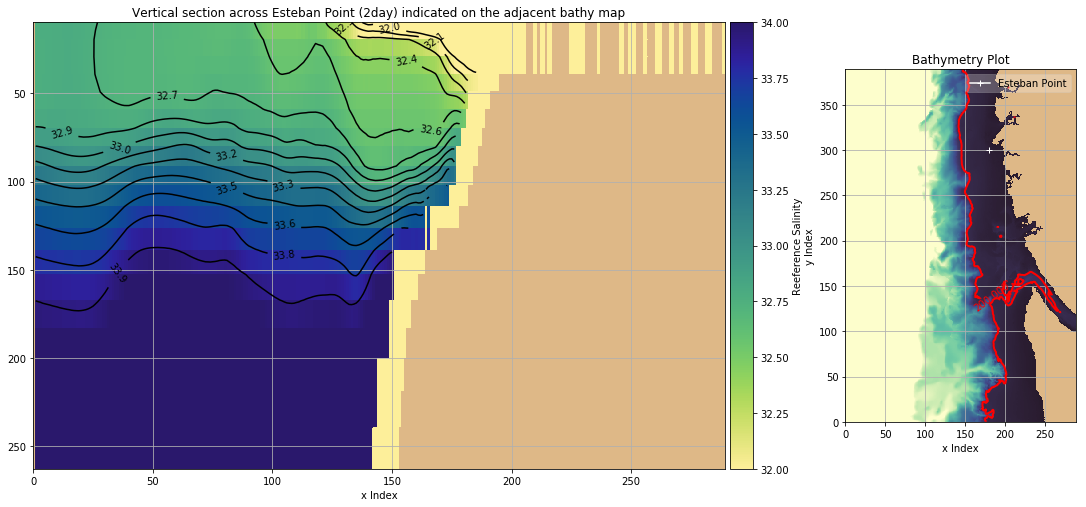

In [92]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[180], y_slice[300],
    linestyle='-', marker='+', color='white',
    label='Esteban Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
# ssh_t = np.ma.masked_equal(ssh[t], 0)
sal_0 = np.ma.masked_array(vosaline_NEMO_2day[:20, :,:], 1-tmask_WCVI[0,:20,:,:])
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], cmap=cmap, vmin=32, vmax=34)
# mesh1 = axl.pcolormesh(x_slice , zlevels[:20], tmask_WCVI[0,:20,300,x_slice], cmap=cmap )
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Esteban Point (2day) indicated on the adjacent bathy map')

In [ ]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[180], y_slice[300],
    linestyle='-', marker='+', color='white',
    label='Esteban Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
# ssh_t = np.ma.masked_equal(ssh[t], 0)
sal_0 = np.ma.masked_array(vosaline_NEMO_2day[:20, :,:], 1-tmask_WCVI[0,:20,:,:])
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], cmap=cmap, vmin=32, vmax=34)
# mesh1 = axl.pcolormesh(x_slice , zlevels[:20], tmask_WCVI[0,:20,300,x_slice], cmap=cmap )
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Esteban Point (2day) indicated on the adjacent bathy map')

In [93]:
import numpy as np
import netCDF4 as nc
import xarray as xr
from scipy.interpolate import griddata, interp1d
from salishsea_tools import (nc_tools, gsw_calls,viz_tools)
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm

fname = '/home/ssahu/saurav/JP_BC/cat_42_days_T.nc'

gridT = xr.open_dataset(fname)

mask = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/meshmask_files/JP_mesh_mask.nc')

tmask_JP = mask.variables['tmask'][0,:,55:420,446:730]



vosaline_JP = np.array(gridT['vosaline'][21,:,55:420,446:730])
vosaline_JP[...] = np.ma.masked_array(vosaline_JP[...], mask = tmask_JP[...])
vosaline_JP[vosaline_JP == 0] = ['Nan']

glamt_bc_JP = np.array(gridT['nav_lon'][55:420,446:730])
gphit_bc_JP = np.array(gridT['nav_lat'][55:420,446:730])
deptht_JP = np.array(gridT['deptht'][:])

print("Removing Nan values from JP's data, since we replaced the zero masks with Nans")



#fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc'

with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...];

X = glamt_bc_JP.flatten();

Y = gphit_bc_JP.flatten();

points = (X[:],Y[:]);

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

vosaline_ic = np.empty((vosaline_JP.shape[0], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));

for i in np.arange(votemper_JP.shape[0]):
    vosaline_ic[i,...] = np.reshape(griddata(points, vosaline_JP[i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)



print("Interpolation to WCVI horizontal points successful")

print("Calling GSW tools to convert to Conservative Temperature and Reference Salinity")


lat = np.empty_like(gphit_wcvi)
lon = np.empty_like(gphit_wcvi)
depth = np.empty_like(deptht_JP)

lat[:] = gphit_wcvi[:]
lon[:] = glamt_wcvi[:]

depth[:] = deptht_JP[:]

z = np.multiply(depth[:],-1)


vosaline_PSU =np.empty_like(vosaline_ic)  

 

vosaline_PSU[:] = vosaline_ic[:]

pressure = np.empty(z.shape)
lats = np.empty(pressure.shape)
lons = np.empty(pressure.shape)
lats[:] = np.mean(lat)
lons[:] = np.mean(lon)


vosaline_SA = np.empty(vosaline_PSU.shape)
vosaline_RS = np.empty(vosaline_PSU.shape)


pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)])

print("Converted z to p: first GSW call successful")

for i in np.arange(vosaline_SA.shape[0]):
    vosaline_SA[i,...] = gsw_calls.generic_gsw_caller('gsw_SA_from_SP', [vosaline_PSU[i,...],pressure[i],lons[i],lats[i]])

print("Got SA from SP: GSW ran successfully inside loop")

vosaline_RS[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_PSU[:]])

print("Reference Salinity obtained from PS: one more GSW call left")




print("GSW Calls successfull")

mask_wcvi = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/meshmask_files/mesh_mask_high_res.nc')

NEMO_depth = mask_wcvi.variables['gdept_0'][0,:,0,0]
tmask_WCVI = mask_wcvi.variables['tmask'][:]


salinity_function = interp1d(depth, vosaline_RS, axis = 0, bounds_error=False, fill_value='extrapolate')


vosaline_NEMO = np.empty((NEMO_depth.shape[0], vosaline_RS.shape[1], vosaline_RS.shape[2]));


for indx in np.arange(NEMO_depth.shape[0]):
    vosaline_NEMO[indx,...] = salinity_function(NEMO_depth[indx]);
    

Removing Nan values from JP's data, since we replaced the zero masks with Nans
Interpolation to WCVI horizontal points successful
Calling GSW tools to convert to Conservative Temperature and Reference Salinity
Converted z to p: first GSW call successful
Got SA from SP: GSW ran successfully inside loop
Reference Salinity obtained from PS: one more GSW call left
GSW Calls successfull


In [94]:
vosaline_NEMO_20day = vosaline_NEMO



print("Vertical Interpolation to WCVI depth levels successful")

Vertical Interpolation to WCVI depth levels successful


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/ssahu/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


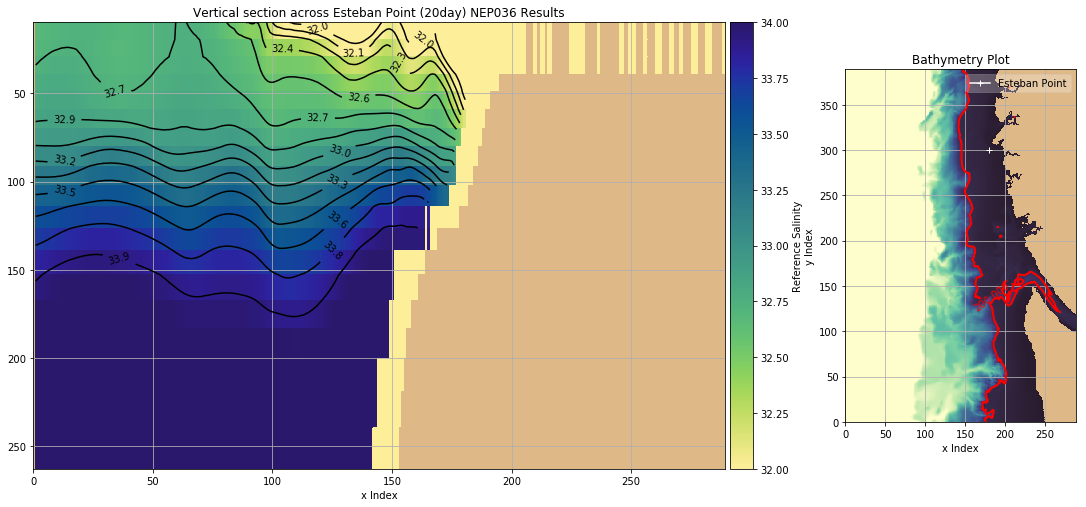

In [97]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[180], y_slice[300],
    linestyle='-', marker='+', color='white',
    label='Esteban Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
# ssh_t = np.ma.masked_equal(ssh[t], 0)
sal_0 = np.ma.masked_array(vosaline_NEMO_20day[:20, :,:], 1-tmask_WCVI[0,:20,:,:])
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], cmap=cmap, vmin=32, vmax=34)
# mesh1 = axl.pcolormesh(x_slice , zlevels[:20], tmask_WCVI[0,:20,300,x_slice], cmap=cmap )
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,300,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Esteban Point (20day) NEP036 Results')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/ssahu/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


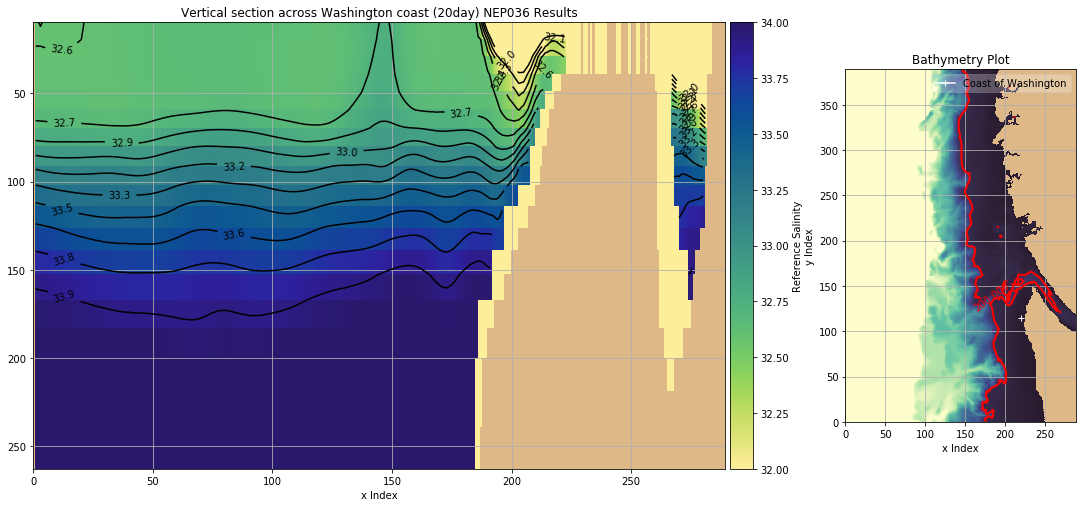

In [100]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[220], y_slice[115],
    linestyle='-', marker='+', color='white',
    label='Coast of Washington',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
# ssh_t = np.ma.masked_equal(ssh[t], 0)
sal_0 = np.ma.masked_array(vosaline_NEMO_2day[:20, :,:], 1-tmask_WCVI[0,:20,:,:])
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,115,x_slice], cmap=cmap, vmin=32, vmax=34)
# mesh1 = axl.pcolormesh(x_slice , zlevels[:20], tmask_WCVI[0,:20,300,x_slice], cmap=cmap )
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,115,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Washington coast (20day) NEP036 Results')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/ssahu/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


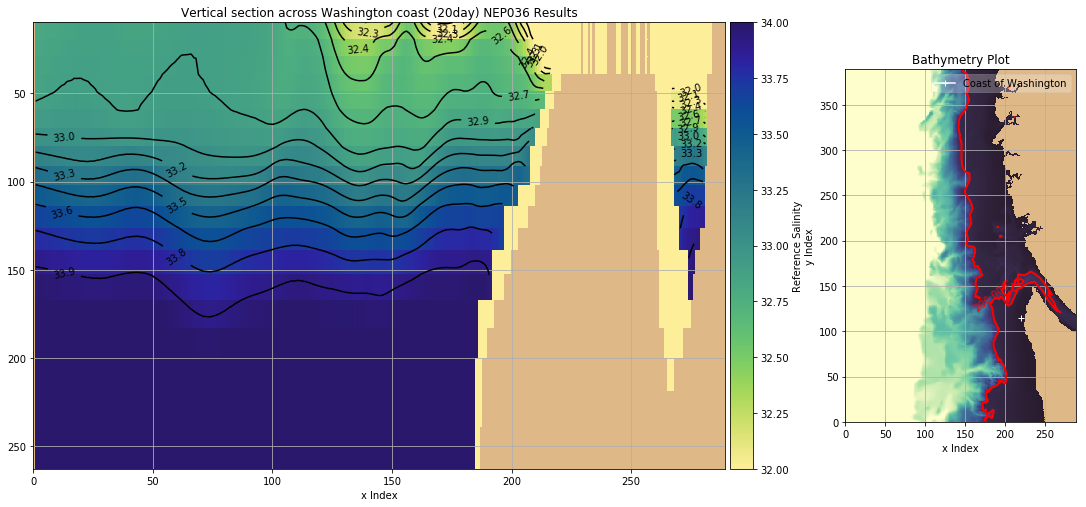

In [101]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_slice, y_slice, Z, cmap=cmap)
axr.plot(
    x_slice[220], y_slice[115],
    linestyle='-', marker='+', color='white',
    label='Coast of Washington',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_slice,y_slice,Z, levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 47 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
# ssh_t = np.ma.masked_equal(ssh[t], 0)
sal_0 = np.ma.masked_array(vosaline_NEMO_20day[:20, :,:], 1-tmask_WCVI[0,:20,:,:])
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_slice, zlevels[:20])
mesh = axl.pcolormesh(x_slice, zlevels[:20], sal_tzyx[:20,115,x_slice], cmap=cmap, vmin=32, vmax=34)
# mesh1 = axl.pcolormesh(x_slice , zlevels[:20], tmask_WCVI[0,:20,300,x_slice], cmap=cmap )
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Reference Salinity')
clines = axl.contour(x_slice, zlevels[:20], sal_tzyx[:20,115,x_slice], np.arange(32, 34, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Washington coast (20day) NEP036 Results')

In [75]:
vosaline_NEMO_2day.shape

(40, 390, 290)

In [115]:



from   grid_alignment import calculate_initial_compass_bearing as cibc


mask = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/meshmask_files/JP_mesh_mask.nc')

tmask_JP = mask.variables['tmask'][0,:,55:420,446:730]
umask_JP = mask.variables['umask'][0,:,55:420,446:730]
vmask_JP = mask.variables['vmask'][0,:,55:420,446:730]


grid_JP = xr.open_dataset('/ocean/ssahu/JP_BC/coordinates_JP.nc')

glamt_bc_JP = np.array(grid_JP.variables['glamt'][55:420,446:730]); gphit_bc_JP = np.array(grid_JP.variables['gphit'][55:420,446:730])

glamu = np.array(grid_JP.variables['glamu'][55:420,446:730]); gphiu = np.array(grid_JP.variables['gphiu'][55:420,446:730])
glamv = np.array(grid_JP.variables['glamv'][55:420,446:730]); gphiv = np.array(grid_JP.variables['gphiv'][55:420,446:730])


fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc'

with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...]
    glamt_wcvi = coord.variables['glamt'][0,...]
    glamu_wcvi = coord.variables['glamu'][0,...]
    gphiu_wcvi = coord.variables['gphiu'][0,...]
    glamv_wcvi = coord.variables['glamv'][0,...]
    gphiv_wcvi = coord.variables['gphiv'][0,...]





gridU = xr.open_dataset('/home/ssahu/saurav/JP_BC/cat_43_U.nc')
gridV = xr.open_dataset('/home/ssahu/saurav/JP_BC/cat_43_V.nc')


nav_lon_U = np.array(gridU['nav_lon'][55:420,446:730])
nav_lat_U = np.array(gridU['nav_lat'][55:420,446:730])

nav_lon_V = np.array(gridV['nav_lon'][55:420,446:730])
nav_lat_V = np.array(gridV['nav_lat'][55:420,446:730]) 

U_vel_BC_unfiltered = np.array(gridU['vozocrtx'][2,:,55:420,446:730])
V_vel_BC_unfiltered = np.array(gridV['vomecrty'][2,:,55:420,446:730])



U_vel_BC = np.empty(U_vel_BC_unfiltered.shape)
V_vel_BC = np.empty(V_vel_BC_unfiltered.shape)

print("Starting to filter the JP velocities")

# for idx, val in enumerate(U_vel_BC_unfiltered[:,...]):
#     U_vel_BC[idx-1,...] = U_vel_BC_unfiltered[idx-2,...]*0.25 + U_vel_BC_unfiltered[idx-1,...]*0.5 + \
#                                U_vel_BC_unfiltered[idx,...]*0.25
#     V_vel_BC[idx-1,...] = V_vel_BC_unfiltered[idx-2,...]*0.25 + V_vel_BC_unfiltered[idx-1,...]*0.5 + \
#                                V_vel_BC_unfiltered[idx,...]*0.25

U_vel_BC = U_vel_BC_unfiltered
V_vel_BC = V_vel_BC_unfiltered

print("The velocities are filtered")

for i in np.arange(U_vel_BC.shape[0]):
    U_vel_BC[i,...] = ma.masked_array(U_vel_BC[i,...], mask = umask_JP[0,...])
    V_vel_BC[i,...] = ma.masked_array(V_vel_BC[i, ...], mask = vmask_JP[0,...])

print("Beginning to do the grid transformation process for the vector fields to match WCVI domain")


# "Unstagger" the velocity values by interpolating them to the T-grid points
u_vel_BC_tzyx, v_vel_BC_tzyx = viz_tools.unstagger(U_vel_BC, V_vel_BC)

mag_vel_BC = np.sqrt(np.multiply(u_vel_BC_tzyx,u_vel_BC_tzyx), np.multiply(v_vel_BC_tzyx,v_vel_BC_tzyx));
ang_vel_BC = np.degrees(np.arctan2(v_vel_BC_tzyx, u_vel_BC_tzyx));


# First point
lonA = glamu[:,0:-1]
latA = gphiu[:,0:-1]
# Second point
lonB = glamu[:,1:]
latB = gphiu[:,1:]


bearing = cibc((latA,lonA),(latB,lonB))
angle_needed = 90 - bearing;

angle_unrotated = np.empty((ang_vel_BC.shape[0],ang_vel_BC.shape[1], ang_vel_BC.shape[2]))


for p in np.arange(ang_vel_BC.shape[0]):
    for i in np.arange(ang_vel_BC.shape[1]):
        angle_unrotated[p,i,...] = ang_vel_BC[p,i,...] + angle_needed[1:,:]
                               
                               
u_unrotated = mag_vel_BC*np.cos(np.radians(angle_unrotated))
v_unrotated = mag_vel_BC*np.sin(np.radians(angle_unrotated))


# First point
lonA_wcvi = glamu_wcvi[:,0:-1]
latA_wcvi = gphiu_wcvi[:,0:-1]
# Second point
lonB_wcvi = glamu_wcvi[:,1:]
latB_wcvi = gphiu_wcvi[:,1:]


bearing_wcvi = cibc((latA_wcvi,lonA_wcvi),(latB_wcvi,lonB_wcvi))
angle_needed_wcvi = 90 - bearing_wcvi



glamt_cut_JP = glamt_bc_JP[1:,1:]
gphit_cut_JP = gphit_bc_JP[1:,1:]

X = np.array(glamt_cut_JP).flatten()
Y = np.array(gphit_cut_JP).flatten()

points = (X[:],Y[:]);

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

u_unrotated_wcvi_t = np.empty((u_unrotated.shape[0],u_unrotated.shape[1],glamt_wcvi.shape[0], glamt_wcvi.shape[1]));
v_unrotated_wcvi_t = np.empty((v_unrotated.shape[0],v_unrotated.shape[1],glamt_wcvi.shape[0], glamt_wcvi.shape[1]));

for p in np.arange(u_unrotated.shape[0]):
    for i in np.arange(v_unrotated.shape[1]):
        u_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, u_unrotated[p,i,:,...].flatten(), \
                                                xi, method= 'linear'), glamt_wcvi.shape)
        v_unrotated_wcvi_t[p,i,...] = np.reshape(griddata(points, v_unrotated[p,i,...].flatten(), \
                                                xi, method= 'linear'), glamt_wcvi.shape)


mag_vel_at_wcvi = np.sqrt(np.multiply(u_unrotated_wcvi_t,u_unrotated_wcvi_t), \
                         np.multiply(v_unrotated_wcvi_t,v_unrotated_wcvi_t));

ang_vel_at_wcvi = np.degrees(np.arctan2(v_unrotated_wcvi_t, u_unrotated_wcvi_t));

angle_unrotated_wcvi = ang_vel_at_wcvi[...,:,1:] - angle_needed_wcvi;

u_unrotated_rotated_to_wcvi = mag_vel_at_wcvi[...,:,1:]*(np.cos(np.radians(angle_unrotated_wcvi[...])));
v_unrotated_rotated_to_wcvi = mag_vel_at_wcvi[...,:,1:]*(np.sin(np.radians(angle_unrotated_wcvi[...])));


def stagger(ugrid, vgrid):
    u = np.add(ugrid[...,:-1], ugrid[...,1:]) / 2;
    v = np.add(vgrid[...,:-1, :], vgrid[...,1:, :]) / 2;
    return u[...,:, :], v[...,:, :]


u_rotated_WCVI, v_rotated_WCVI = stagger(u_unrotated_rotated_to_wcvi, v_unrotated_rotated_to_wcvi)

print("Vector Grid transformation complete and veloctities staggered")

Starting to filter the JP velocities
The velocities are filtered
Beginning to do the grid transformation process for the vector fields to match WCVI domain


ValueError: could not broadcast input array from shape (364,268) into shape (268)

In [112]:
ang_vel_BC.shape

(50, 364, 268)

In [ ]:
v_2day = v_rotated_WCVI